<a href="https://www.kaggle.com/code/loananh/linear-regression?scriptVersionId=227340733" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Prepare Python Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Load Dataframe
data = pd.read_csv('/kaggle/input/hose-market/CafeF.HSX.Upto07.03.2025.csv')

# Rename column <DTYYYYMMDD> to Date
data.rename(columns={'<DTYYYYMMDD>': '<Date>'}, inplace=True)

# Convert <DTYYYYMMDD> from number to date format
data['<Date>'] = pd.to_datetime(data['<Date>'], format='%Y%m%d')

# Filter Stock Data for Analytics (SSI Stock in 7,5 years)
start_date = datetime.now()
end_date = start_date - pd.DateOffset(years=8, months=6)
df = data[(data['<Ticker>']=='SSI') & (data['<Date>'] >= end_date) & (data['<Date>'] <= start_date)]

# Sort date and index in ascending
df = df.iloc[::-1]
df = df.reset_index(drop = True, inplace = False)

print(df.head())
print(df.tail())

#Get the duration of data set
print("Starting date: ", df.iloc[0]['<Date>'])
print("Ending date: ", df.iloc[-1]['<Date>'])
print("Duration: ", df.iloc[-1]['<Date>'] - df.iloc[0]['<Date>'])

  <Ticker>     <Date>  <Open>  <High>   <Low>  <Close>  <Volume>
0      SSI 2016-09-14  6.6150  6.6465  6.6150   6.6167   1518240
1      SSI 2016-09-15  6.6150  6.6308  6.5520   6.5537   1797440
2      SSI 2016-09-16  6.5520  6.6150  6.5205   6.5537   4373810
3      SSI 2016-09-19  6.6150  6.7725  6.6150   6.7585   1667500
4      SSI 2016-09-20  6.7568  6.8355  6.6780   6.7900   1784010
     <Ticker>     <Date>  <Open>  <High>  <Low>  <Close>  <Volume>
2112      SSI 2025-03-03   26.30   26.80  26.15    26.60  25645100
2113      SSI 2025-03-04   26.45   26.60  26.10    26.35  24072400
2114      SSI 2025-03-05   26.40   26.65  26.10    26.10  27564200
2115      SSI 2025-03-06   26.20   26.95  26.20    26.90  44988800
2116      SSI 2025-03-07   27.10   27.15  26.80    26.90  22896800
Starting date:  2016-09-14 00:00:00
Ending date:  2025-03-07 00:00:00
Duration:  3096 days 00:00:00


In [2]:
# Create features for prediction
df['Days'] = range(len(df))
X = df[['Days']]
y = df['<Close>']

# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Print model metrics
print("\nModel Performance Metrics:")
print(f"R-squared Score: {model.score(X, y):.4f}")
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")


Model Performance Metrics:
R-squared Score: 0.5863
Coefficient: 0.0105
Intercept: 4.4115


In [3]:
# Create future dates for prediction (15 days)
last_date = df['<Date>'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15, freq='B')
future_days = range(len(df), len(df) + 15)

# Make predictions
future_X = pd.DataFrame({'Days': future_days})
future_predictions = model.predict(future_X)

# Calculate confidence intervals using statsmodels
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()
future_X_sm = sm.add_constant(future_X)
forecast_ci = sm_model.get_prediction(future_X_sm).conf_int()

# Print forecast results
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': np.round(future_predictions, 2),
    'CI_Lower': np.round(forecast_ci[:, 0], 2),
    'CI_Upper': np.round(forecast_ci[:, 1], 2)
})
print("\nPrice Forecast for next 15 business days:")
pd.set_option('display.float_format', '{:.2f}'.format)
print(forecast_df)


Price Forecast for next 15 business days:
         Date  Predicted_Price  CI_Lower  CI_Upper
0  2025-03-10            26.66     26.20     27.12
1  2025-03-11            26.67     26.21     27.13
2  2025-03-12            26.68     26.22     27.14
3  2025-03-13            26.69     26.23     27.15
4  2025-03-14            26.70     26.24     27.16
5  2025-03-17            26.71     26.25     27.17
6  2025-03-18            26.72     26.26     27.18
7  2025-03-19            26.73     26.27     27.20
8  2025-03-20            26.74     26.28     27.21
9  2025-03-21            26.75     26.29     27.22
10 2025-03-24            26.76     26.30     27.23
11 2025-03-25            26.77     26.31     27.24
12 2025-03-26            26.79     26.32     27.25
13 2025-03-27            26.80     26.33     27.26
14 2025-03-28            26.81     26.34     27.27


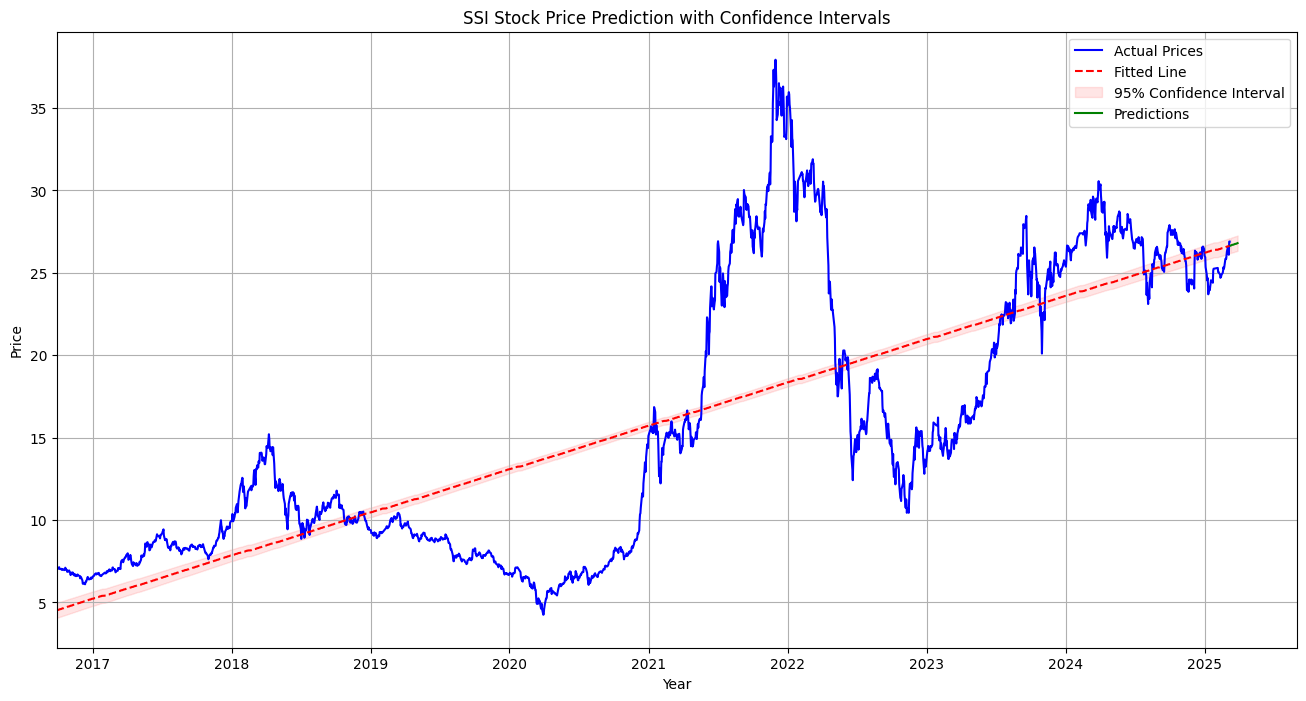

In [4]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(df['<Date>'], df['<Close>'], label='Actual Prices', color='blue')

# Generate predictions summary frame for the existing data
predictions_summary_frame = sm_model.get_prediction(X_sm).summary_frame(alpha=0.05)

plt.plot(df['<Date>'], predictions_summary_frame['mean'], 'r--', label='Fitted Line')
plt.fill_between(df['<Date>'], 
                  predictions_summary_frame['mean_ci_lower'],
                  predictions_summary_frame['mean_ci_upper'],
                  color='red', alpha=0.1, label='95% Confidence Interval')

# Future predictions with confidence intervals
future_X = sm.add_constant(future_X)
future_predictions = sm_model.get_prediction(future_X)
future_summary_frame = future_predictions.summary_frame(alpha=0.05)

plt.plot(future_dates, future_summary_frame['mean'], label='Predictions', color='green')
plt.fill_between(future_dates,
                 future_summary_frame['mean_ci_lower'],
                 future_summary_frame['mean_ci_upper'],
                 color='red', alpha=0.1)

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('SSI Stock Price Prediction with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.xlim(df['<Date>'].min() + pd.Timedelta(days=15))
plt.show()